In [1]:
#!/usr/bin/env python3

import os
import sys
import re
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
from torchvision import transforms
import torch
torch.manual_seed(42)
np.random.seed(42)

REPO_PATH = '/Users/azgarian/Documents/myprojects/aiproject'

os.chdir(REPO_PATH)
sys.path.append(REPO_PATH)

def augment_image(image):
    """Apply soft augmentation to a PIL image and return the augmented image."""
    augment_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
    ])
    return augment_transform(image)

def generate_augmented(class_data, class_label, n_augmentations, save_dir):
    """Generate and save n_augmentations for a class using augment_image."""
    augmented = []
    current_size = len(class_data)
    aug_count = 0
    while aug_count < n_augmentations:
        idx = np.random.randint(0, current_size)
        image_path, _ = class_data[idx]
        image = Image.open(image_path).convert('RGB')
        augmented_image = augment_image(image)
        aug_path = os.path.join(save_dir,
                                f'aug_{class_label}_{aug_count}_{os.path.basename(image_path)}')
        augmented_image.save(aug_path)
        augmented.append((aug_path, class_label))
        aug_count += 1
    return augmented

import shutil
import os

def balance_dataset(dataset, target_size=10000, base_save_dir='data/train', overwrite=False):
    """Balance the dataset by augmenting both classes, saving to class-specific directories."""
    class_dirs = {
        0: os.path.join(base_save_dir, '1_root_images'),
        1: os.path.join(base_save_dir, '2_root_images')
    }
    for save_dir in class_dirs.values():
        if overwrite and os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        os.makedirs(save_dir, exist_ok=True)
    class_0_data = [(path, label) for path, label in dataset if label == 0]
    class_1_data = [(path, label) for path, label in dataset if label == 1]
    target_per_class = target_size // 2
    augmented_data = []
    for class_data, class_label in [(class_0_data, 0), (class_1_data, 1)]:
        save_dir = class_dirs[class_label]
        current_size = len(class_data)

        originals = []
        for i, (path, _) in enumerate(class_data):
            dest_path = os.path.join(save_dir, f'orig_{i}_{os.path.basename(path)}')
            if not os.path.exists(dest_path):
                shutil.copy2(path, dest_path)
            originals.append((dest_path, class_label))
        n_augmentations = target_per_class - current_size
        augmented = generate_augmented(class_data, class_label, n_augmentations, save_dir)
        augmented_data.extend(originals)
        augmented_data.extend(augmented)
    final_class_0 = len([x for x in augmented_data if x[1] == 0])
    final_class_1 = len([x for x in augmented_data if x[1] == 1])
    print(f"\nFinal dataset class distribution:")
    print(f"Class 0 (Single root): {final_class_0}")
    print(f"Class 1 (Double root): {final_class_1}")
    print(f"Total samples: {len(augmented_data)}")
    return augmented_data

def save_images_to_class_folders(data, base_save_dir='data'):
    import shutil, os
    class_dirs = {
        0: os.path.join(base_save_dir, '1_root_images'),
        1: os.path.join(base_save_dir, '2_root_images')
    }
    for save_dir in class_dirs.values():
        os.makedirs(save_dir, exist_ok=True)
    class_counts = {0: 0, 1: 0}
    for src_path, label in data:
        dest_dir = class_dirs[label]
        dest_path = os.path.join(dest_dir, os.path.basename(src_path))
        if not os.path.exists(dest_path):
            shutil.copy2(src_path, dest_path)
        class_counts[label] += 1
    print(f"Saved {class_counts[0]} images to {class_dirs[0]}")
    print(f"Saved {class_counts[1]} images to {class_dirs[1]}")
    print(f"Total images saved: {class_counts[0] + class_counts[1]}")


def evaluate_images(aug_dir, n_samples=16):
    """Evaluate and visualize augmented images in a directory."""
    import matplotlib.pyplot as plt
    files = [f for f in os.listdir(aug_dir) if f.endswith('.jpeg')]
    # Visualize a grid of random samples
    sample_files = np.random.choice(files, min(n_samples, len(files)), replace=False)
    plt.figure(figsize=(12, 8))
    for i, f in enumerate(sample_files):
        img = Image.open(os.path.join(aug_dir, f)).convert('RGB')
        plt.subplot(int(np.sqrt(n_samples)), int(np.ceil(n_samples/np.sqrt(n_samples))), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f)
    plt.suptitle(f'Random Augmented Images from {aug_dir}')
    plt.tight_layout()
    plt.show()


In [3]:

# Load image paths and labels from data directory (as in train_colab.py)
data_dir = os.path.join(REPO_PATH, "data", "pano", "cropped_images_preprocessed")
single_root_dir = os.path.join(data_dir, "1_root_images")
double_root_dir = os.path.join(data_dir, "2_root_images")
single_root_images = [os.path.join(single_root_dir, f) for f in os.listdir(single_root_dir)
                        if f.endswith('.jpeg')]
double_root_images = [os.path.join(double_root_dir, f) for f in os.listdir(double_root_dir)
                        if f.endswith('.jpeg')]
image_paths = single_root_images + double_root_images
labels = [0] * len(single_root_images) + [1] * len(double_root_images)

# 60/20/20 split

# 1. Group images by patient
patient_to_images = {}
for path, label in zip(image_paths, labels):
    patient_id = os.path.basename(path).split('_')[0]
    if patient_id not in patient_to_images:
        patient_to_images[patient_id] = []
    patient_to_images[patient_id].append((path, label))

# 2. Split patient IDs
all_patients = list(patient_to_images.keys())
trainval_patients, test_patients = train_test_split(all_patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(trainval_patients, test_size=0.25, random_state=42)
# Now: train=60%, val=20%, test=20% (by patient)

# 3. Assign images to splits
train_data = [img for pid in train_patients for img in patient_to_images[pid]]
balanced_train_data = balance_dataset(train_data, target_size=10000,
                                      base_save_dir=os.path.join(data_dir, 'train'),
                                      overwrite=True)
val_data = [img for pid in val_patients for img in patient_to_images[pid]]
save_images_to_class_folders(val_data, base_save_dir=os.path.join(data_dir, 'val'))
test_data = [img for pid in test_patients for img in patient_to_images[pid]]
save_images_to_class_folders(test_data, base_save_dir=os.path.join(data_dir, 'test'))





Final dataset class distribution:
Class 0 (Single root): 5000
Class 1 (Double root): 5000
Total samples: 10000
Saved 126 images to /Users/azgarian/Documents/myprojects/aiproject/data/pano/cropped_images_preprocessed/val/1_root_images
Saved 32 images to /Users/azgarian/Documents/myprojects/aiproject/data/pano/cropped_images_preprocessed/val/2_root_images
Total images saved: 158
Saved 125 images to /Users/azgarian/Documents/myprojects/aiproject/data/pano/cropped_images_preprocessed/test/1_root_images
Saved 33 images to /Users/azgarian/Documents/myprojects/aiproject/data/pano/cropped_images_preprocessed/test/2_root_images
Total images saved: 158


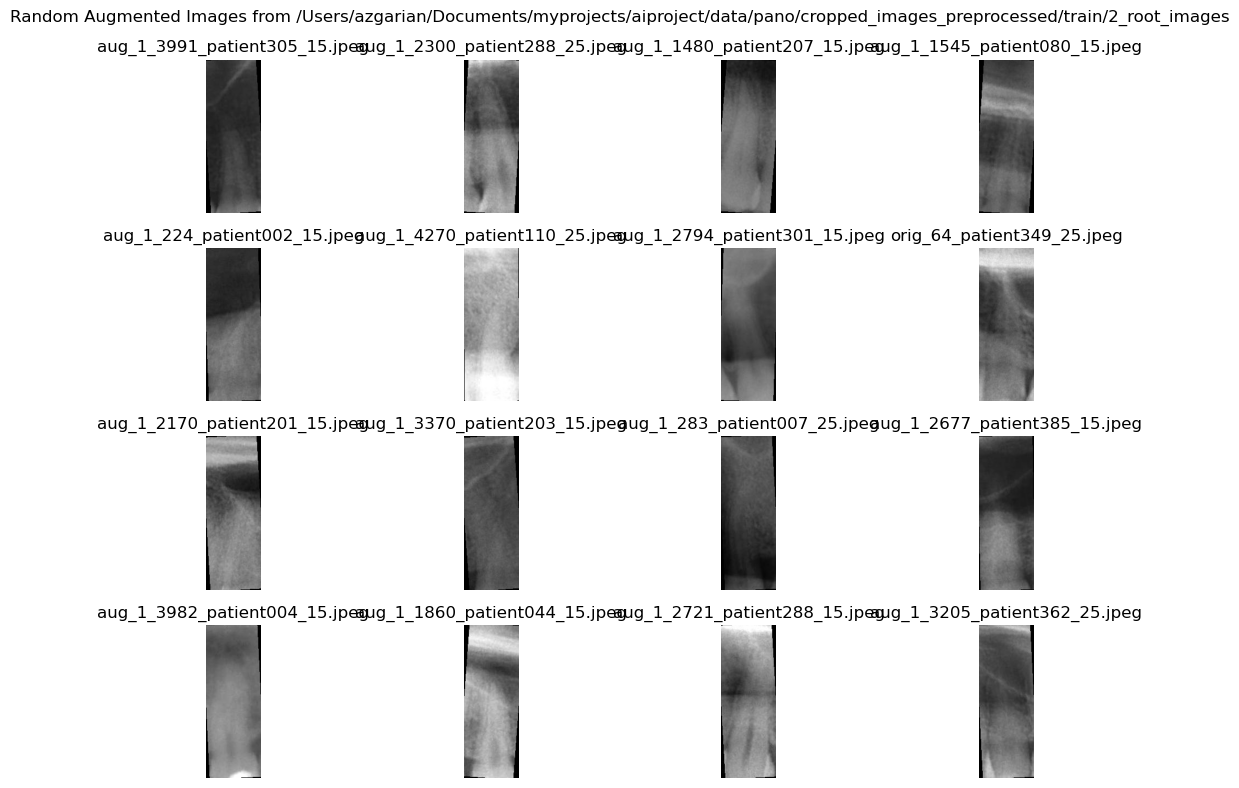

In [5]:
# Evaluate the augmented images
aug_dir = os.path.join(data_dir, 'train', '2_root_images')
evaluate_images(aug_dir, n_samples=16)

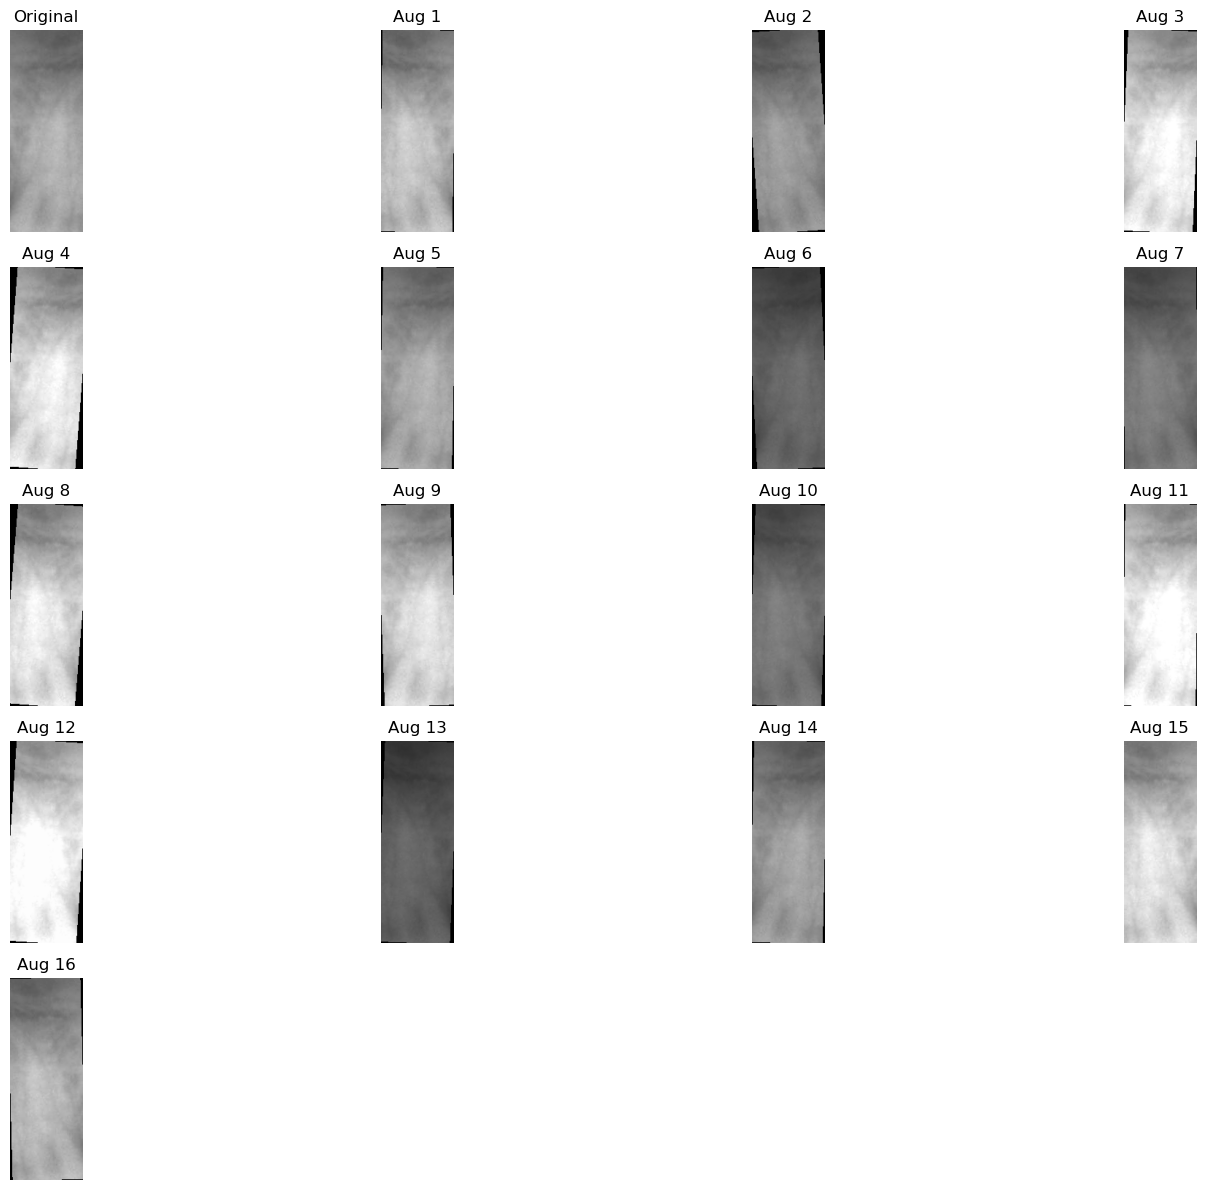

In [7]:
def visualize_augmentations_for_image(image_path, n=8):
    """
    Apply the augmentation pipeline to a single image n times and visualize the results.
    """

    data_dir = os.path.join(REPO_PATH, image_path)

    import matplotlib.pyplot as plt
    from PIL import Image
    import random
    # List all jpeg files
    files = [f for f in os.listdir(data_dir) if f.endswith('.jpeg')]
    if not files:
        print(f"No jpeg files found in {data_dir}")
        return
    # Select a random file
    image_file = random.choice(files)
    image_path = os.path.join(data_dir, image_file)
    image = Image.open(image_path).convert('RGB')
    augment_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
    ])

    plt.figure(figsize=(3 * (n // 4 + 1), 12))
    # Show original
    plt.subplot(n // 4 + 1, 4, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Show augmentations
    for i in range(n):
        aug_img = augment_transform(image)
        plt.subplot(n // 4 + 1, 4, i + 2)
        plt.imshow(aug_img)
        plt.title(f'Aug {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

aug_dir = os.path.join(data_dir, '2_root_images')
visualize_augmentations_for_image(aug_dir, n=16)